In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_correspondences(image1, image2):
    sift = cv2.SIFT_create()
    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Use Brute-Force Matcher with KNN
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

    # Get points from matches
    correspondences = []
    for match in good_matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        point1 = keypoints1[img1_idx].pt
        point2 = keypoints2[img2_idx].pt
        correspondences.append((point1, point2))

    # Draw matches
    matched_image = cv2.drawMatches(
        image1, keypoints1, image2, keypoints2, good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title("Top 50 Matches")
    plt.show()

    return correspondences

def compute_homography(correspondences):
    A = []
    for (x1, y1), (x2, y2) in correspondences:
        A.append([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])
    A = np.array(A)

    # Solve for H using SVD
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H / H[2, 2]

# Verify Homography
def apply_homography(H, points):
    transformed_points = []
    for point in points:
        x, y = point
        vec = np.array([x, y, 1])
        result = np.dot(H, vec)
        transformed_points.append((result[0] / result[2], result[1] / result[2]))
    return transformed_points

def verify_homography(image1, image2, correspondences, H):
    points1 = [pair[0] for pair in correspondences]
    points2 = [pair[1] for pair in correspondences]

    # Apply homography to points1
    transformed_points1 = apply_homography(H, points1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    for pt in points1:
        plt.scatter(*pt, color='red', s=15)
    plt.title("Original Points (Image 1)")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    for pt, t_pt in zip(points2, transformed_points1):
        plt.scatter(*pt, color='blue', s=15)
        plt.scatter(*t_pt, color='yellow', s=15)
    plt.title("Transformed Points (Image 2)")

    plt.show()

def plot_images(reference_image, warped_image):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
    plt.title("Reference Image ")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title("Warped Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def warp_image_combined(image, H, output_size):
    h_out, w_out = output_size
    h_src, w_src, c = image.shape if len(image.shape) == 3 else (*image.shape, 1)
    
    # Inverse of the homography matrix
    H_inv = np.linalg.inv(H)
    # Create an empty output image
    warped_image = np.zeros((h_out, w_out, c), dtype=image.dtype)

    # Forward warping
    for y_src in range(h_src):
        for x_src in range(w_src):
            src_point = np.array([x_src, y_src, 1])
            dest_point = np.dot(H, src_point)
            x_out = int(dest_point[0] / dest_point[2])
            y_out = int(dest_point[1] / dest_point[2])

            if 0 <= x_out < w_out and 0 <= y_out < h_out:
                warped_image[y_out, x_out] = image[y_src, x_src]

    # Inverse warping
    inverse_warped_image = np.zeros_like(warped_image)
    for y_out in range(h_out):
        for x_out in range(w_out):
            dest_point = np.array([x_out, y_out, 1])
            src_point = np.dot(H_inv, dest_point)
            src_x = src_point[0] / src_point[2]
            src_y = src_point[1] / src_point[2]

            # Check if the transformed point is within the source image bounds
            if 0 <= src_x < w_src and 0 <= src_y < h_src:
                # Bilinear interpolation for inverse warping
                x0, y0 = int(src_x), int(src_y)
                x1, y1 = min(x0 + 1, w_src - 1), min(y0 + 1, h_src - 1)

                # Interpolation weights
                wx, wy = src_x - x0, src_y - y0

                for c_idx in range(c):
                    pixel_value = (
                        (1 - wx) * (1 - wy) * image[y0, x0, c_idx] +
                        wx * (1 - wy) * image[y0, x1, c_idx] +
                        (1 - wx) * wy * image[y1, x0, c_idx] +
                        wx * wy * image[y1, x1, c_idx]
                    )
                    inverse_warped_image[y_out, x_out, c_idx] = pixel_value

    # Combine the forward-warped and inverse-warped images
    final_image = np.copy(warped_image)
    mask = inverse_warped_image.sum(axis=2) > 0  # Non-zero pixels in the inverse warped image
    final_image[mask] = inverse_warped_image[mask]

    # Calculate the bounding box for the warped region
    non_zero_indices = np.nonzero(final_image.sum(axis=2))  # Get non-zero pixel indices (i.e., the warped region)
    y_min, y_max = min(non_zero_indices[0]), max(non_zero_indices[0])
    x_min, x_max = min(non_zero_indices[1]), max(non_zero_indices[1])

    # Crop the warped image to fit the bounding box of the warped region
    cropped_warped_image = final_image[y_min:y_max+1, x_min:x_max+1]

    plot_images(image,cropped_warped_image)

    return final_image

def stitch_images(image2, image1, H):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    corners1 = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32)
    corners2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float32)

    # Convert corners of the second image to homogeneous coordinates
    corners2_homogeneous = np.hstack((corners2, np.ones((corners2.shape[0], 1), dtype=np.float32)))

    # Transform corners of the second image using the homography matrix H
    transformed_corners = (H @ corners2_homogeneous.T).T
    transformed_corners /= transformed_corners[:, 2].reshape(-1, 1)  # Normalize to Cartesian

    # Compute the bounding box of the combined panorama
    all_corners = np.vstack((corners1, transformed_corners[:, :2]))
    
    # Find min and max x and y coordinates for the bounding box
    x_min = np.floor(all_corners[:, 0].min()).astype(int)
    x_max = np.ceil(all_corners[:, 0].max()).astype(int)
    y_min = np.floor(all_corners[:, 1].min()).astype(int)
    y_max = np.ceil(all_corners[:, 1].max()).astype(int)

    # Calculate the output panorama dimensions from the bounding box
    output_width = x_max - x_min
    output_height = y_max - y_min

    # Define the translation matrix to ensure coordinates are non-negative
    translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)

    # Warp the second image using the custom warp function with the translation matrix
    warped_image2 = warp_image_combined(image2, translation_matrix @ H, (output_height, output_width))

    # Create a blank canvas for the panorama
    panorama = np.zeros((output_height, output_width, 3), dtype=image1.dtype)

    # Place the first image on the canvas
    x_offset, y_offset = -x_min, -y_min
    panorama[y_offset:y_offset + h1, x_offset:x_offset + w1] = image1

    # Create a mask for the warped image
    mask = (warped_image2.sum(axis=2) > 0)  # Non-zero pixels in the warped image
    mask_indices = np.nonzero(mask)  # Get indices where mask is True

    # Overlay non-zero pixels from warped_image2 onto the panorama
    panorama[mask_indices[0], mask_indices[1]] = warped_image2[mask_indices[0], mask_indices[1]]
    return panorama

Provided Images

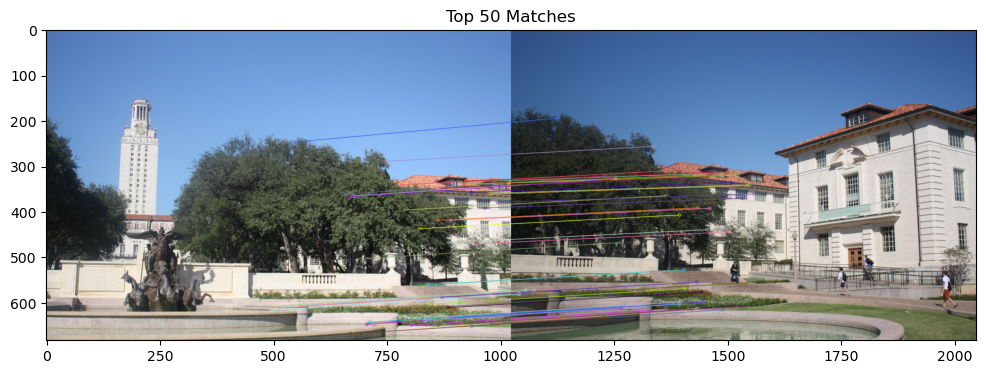

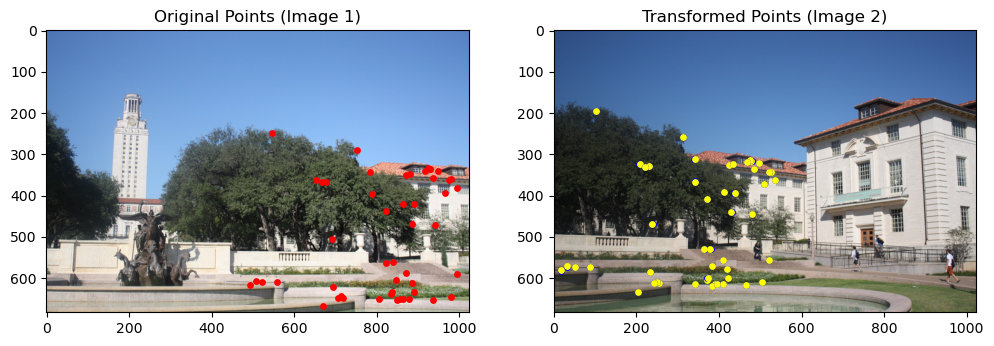

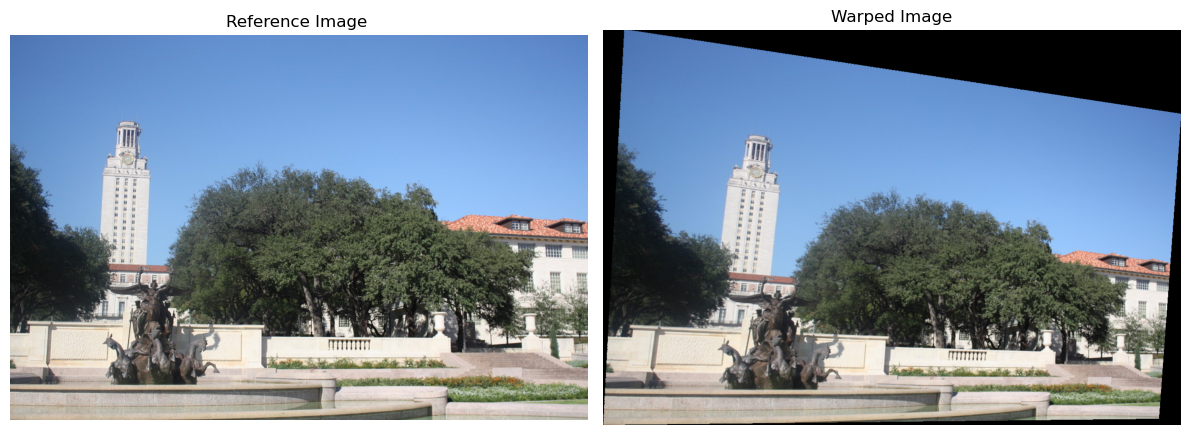

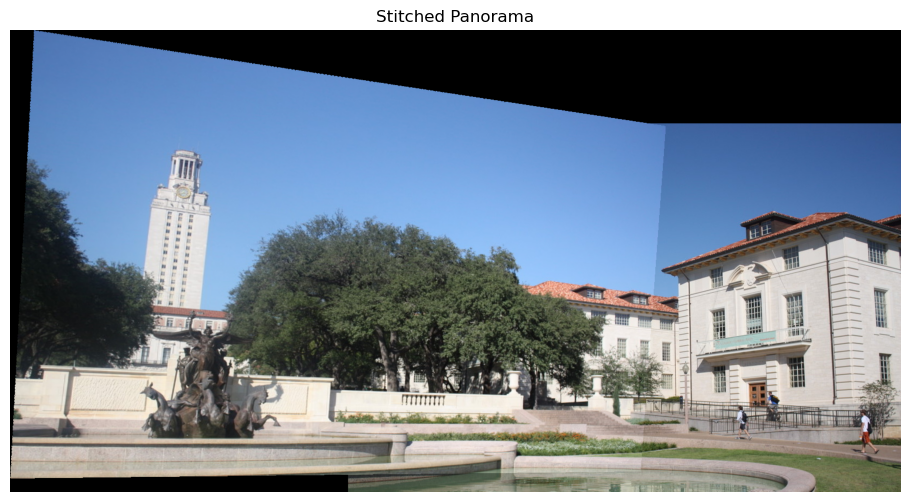

In [2]:
if __name__ == "__main__":

    image1 = cv2.imread(r"pano_image2.jpg")
    image2 = cv2.imread(r"pano_image1.jpg")

    correspondences = get_correspondences(image1, image2)
    H = compute_homography(correspondences)
    verify_homography(image1, image2, correspondences, H)
    panorama = stitch_images(image1, image2, H)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Stitched Panorama")
    plt.show()

Extra Example 1

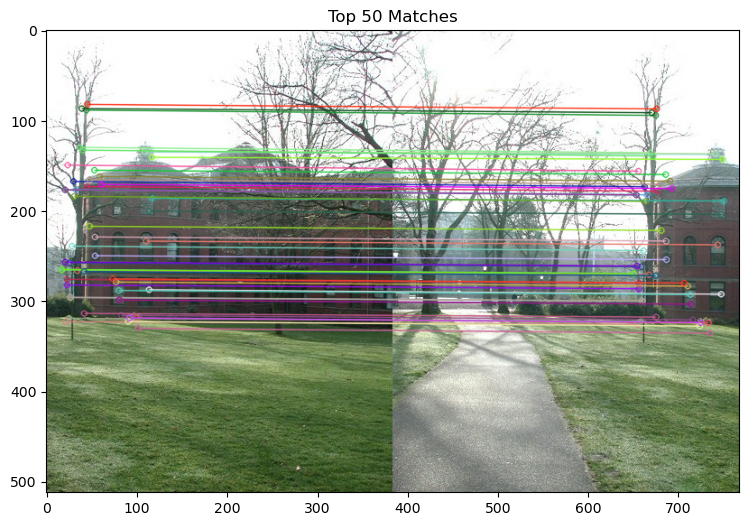

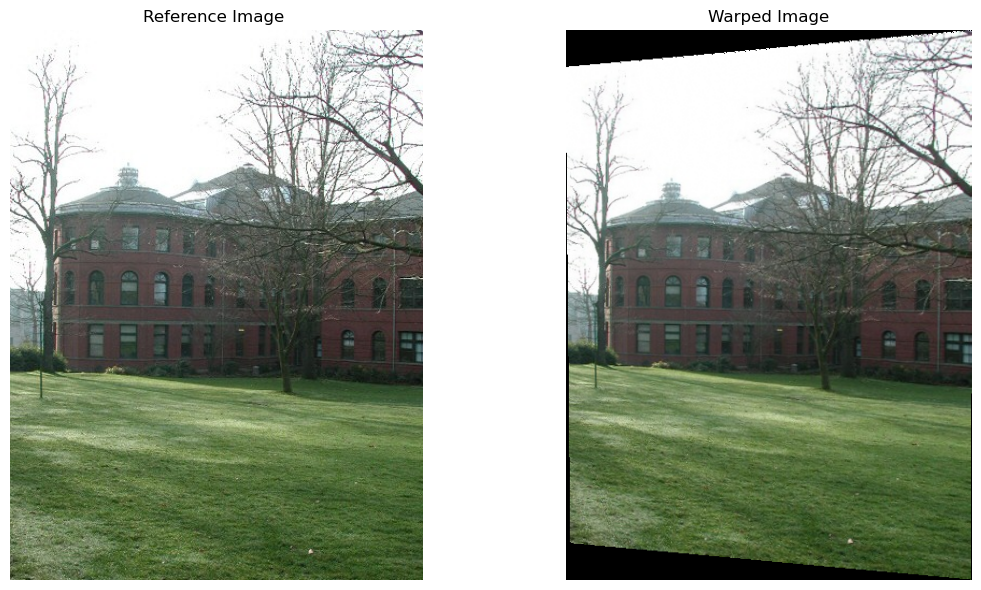

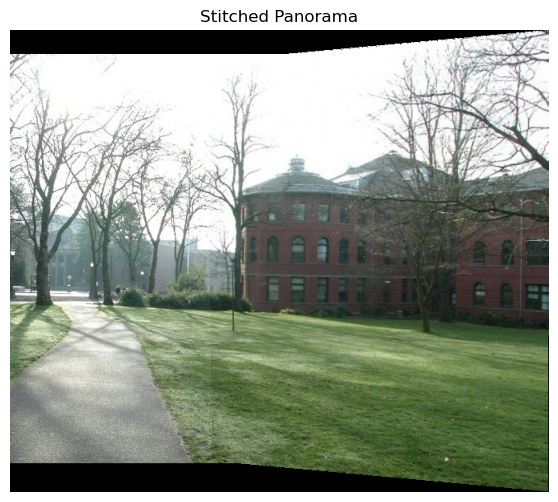

In [3]:
if __name__ == "__main__":

    image1 = cv2.imread(r"house1.jpg")
    image2 = cv2.imread(r"house2.jpg")

    correspondences = get_correspondences(image1, image2)
    H = compute_homography(correspondences)
    panorama = stitch_images(image1, image2, H)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Stitched Panorama")
    plt.show()

Extra Example 2

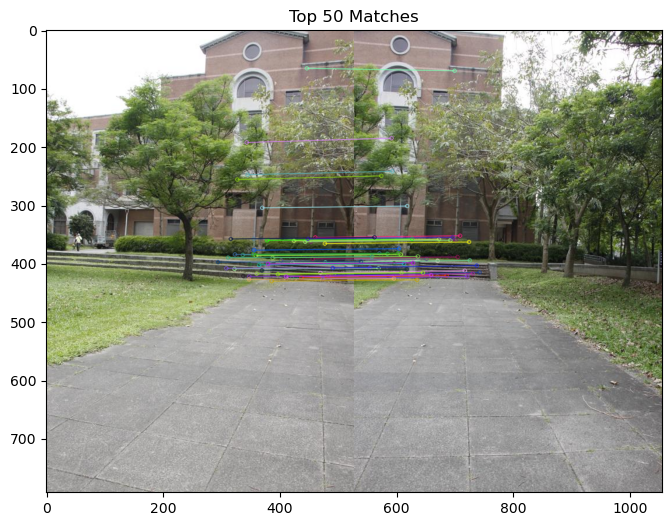

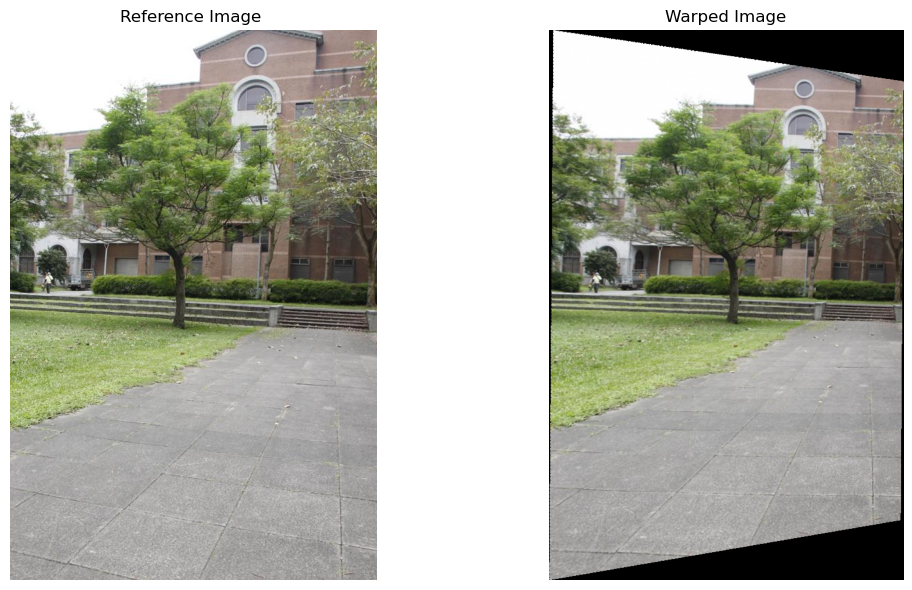

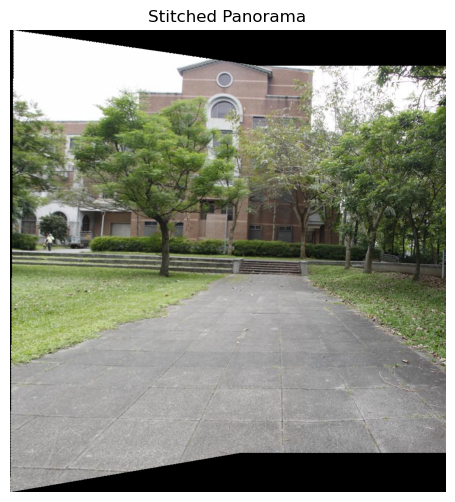

In [4]:
if __name__ == "__main__":

    image1 = cv2.imread(r"building1.jpg")
    image2 = cv2.imread(r"building2.jpg")

    correspondences = get_correspondences(image1, image2)
    H = compute_homography(correspondences)
    panorama = stitch_images(image1, image2, H)

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Stitched Panorama")
    plt.show()

Bonus


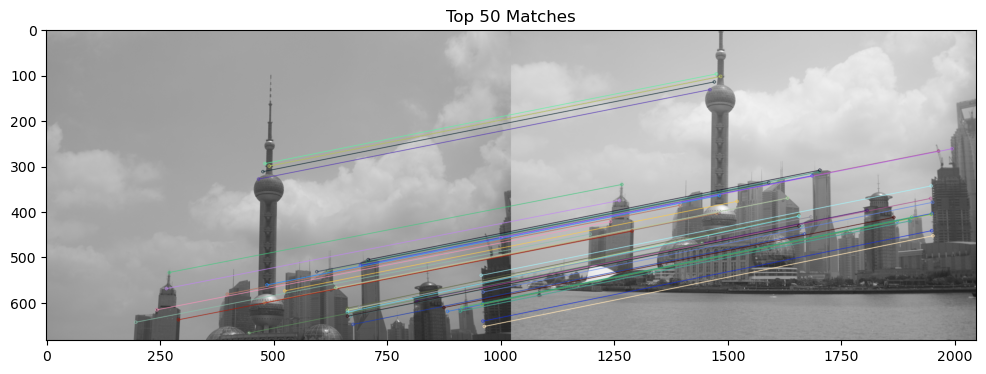

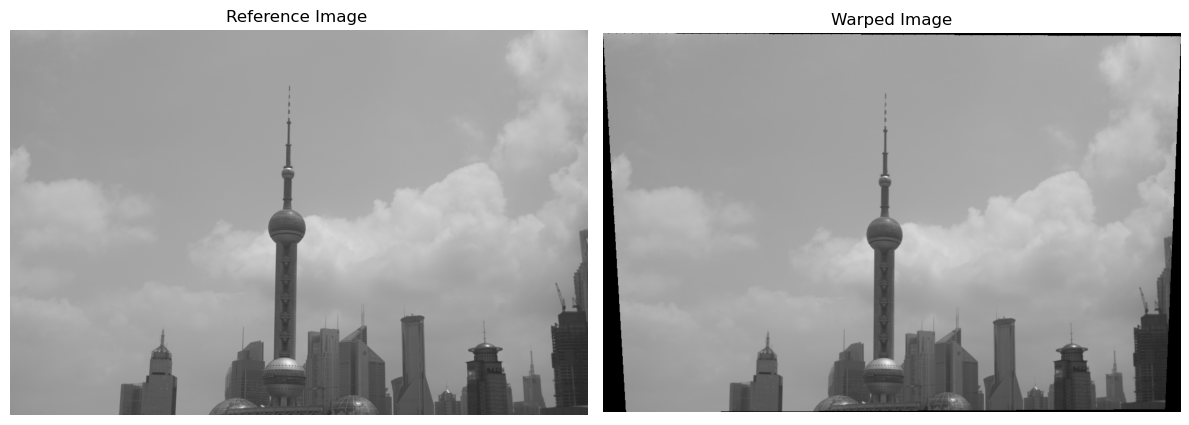

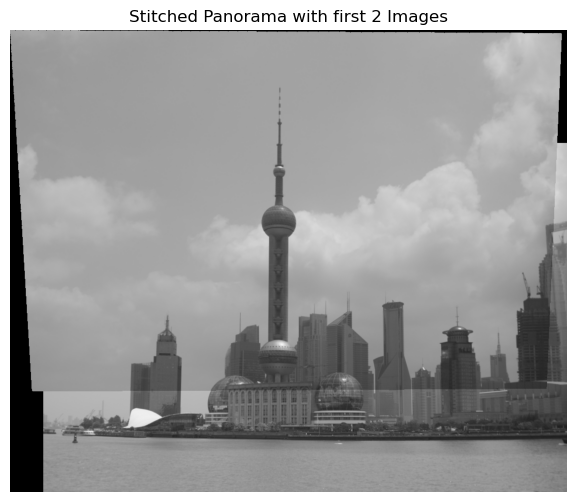

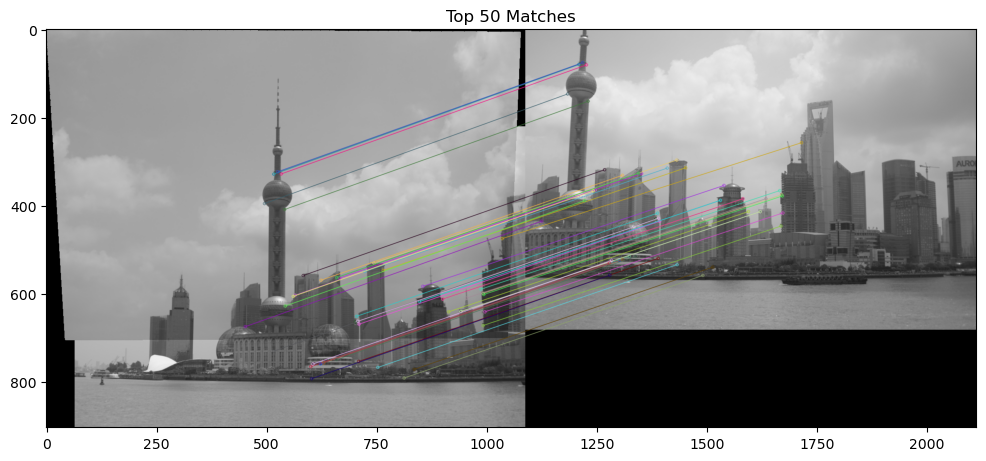

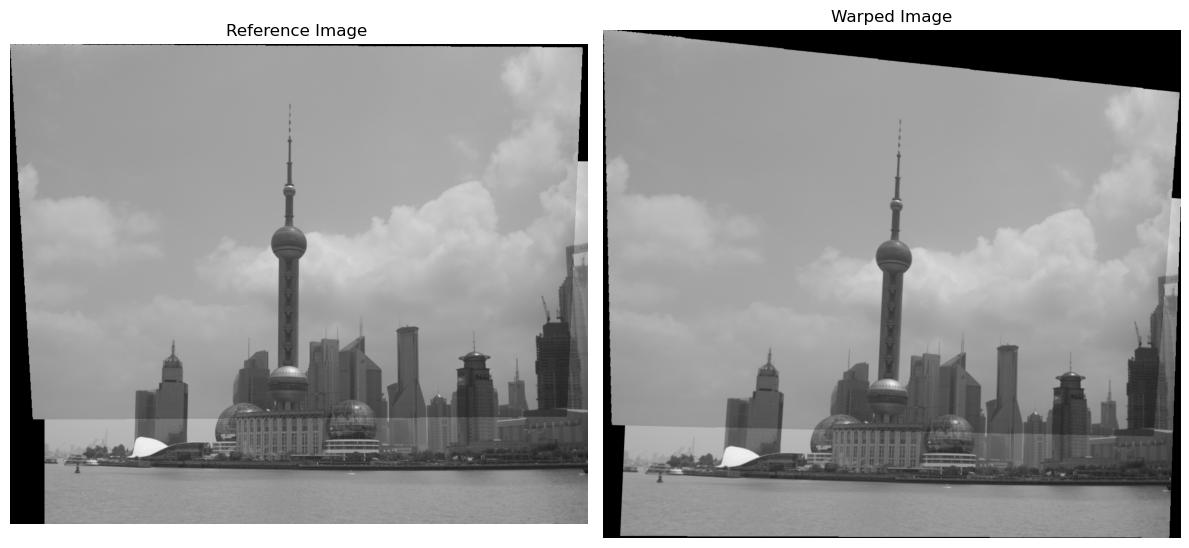

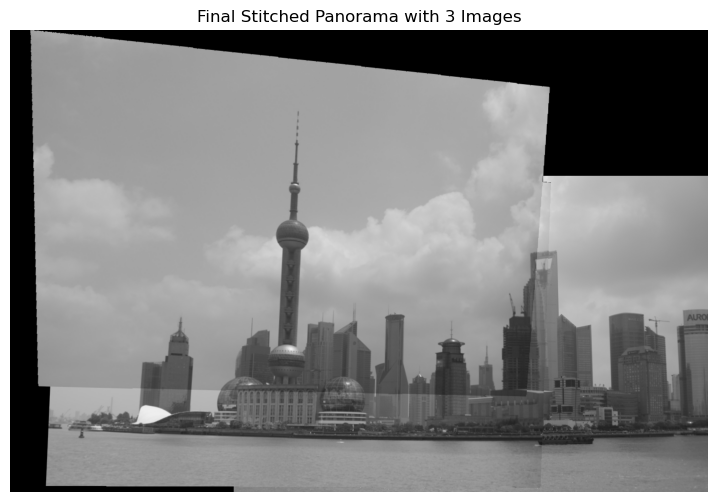

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image1 = cv2.imread(r"shanghai-21.png")
image2 = cv2.imread(r"shanghai-22.png")
image3 = cv2.imread(r"shanghai-23.png")

# Get correspondences between image1 and image2
correspondences_1_2 = get_correspondences(image2, image1)
# Compute the homography matrix for image1 to image2
H_1_2 = compute_homography(correspondences_1_2)
panorama_1_2=stitch_images(image2,image1,H_1_2)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(panorama_1_2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Stitched Panorama with first 2 Images")
plt.show()

# Get correspondences between panorama_1_2 and image3
correspondences_2_3 = get_correspondences(panorama_1_2, image3)
# Compute the homography matrix for panorama_1_2 to image3
H_2_3 = compute_homography(correspondences_2_3)
# Combine the first panorama with the third image, adjusting for the size of the final panorama
panorama_with_image3 = stitch_images(panorama_1_2, image3, H_2_3)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(panorama_with_image3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Final Stitched Panorama with 3 Images")
plt.show()